In [1]:
from google.colab import auth
auth.authenticate_user()
project_id = 'final-year-project-195808'
!gcloud config set project {project_id}
!gsutil cp gs://myharddisk-1/learntoadd_data.pkl /

Updated property [core/project].
Copying gs://myharddisk-1/learntoadd_data.pkl...
- [1 files][  1.8 MiB/  1.8 MiB]                                                
Operation completed over 1 objects/1.8 MiB.                                      


In [4]:
ls

learntoadd_data.pkl


# Practical Assignment for UCCD3074 (Trimester Jan 2018)

## Addition using RNN

This objective of this assignment is to implement a sequence-to-sequence learning for performing addition. The input is a sequence of characters (the addition statement). The expected output is also a sequence of characters (the result). For example:

Input: "535+61"
<br> Output: "596"

**Assumptions:**
* Each character is presented to your system one character at a time. You can make the following assumptions:
* Each number is restricted to a maximum number of digits
* There are no spaces in the middle of the addition statements.
* Spaces can be padded to the left or right of the statements to make the size of each sequence consistent.

**Architecture:**
* A default working architecture has been provided for you. The architecture has been shown to generate an accuracy of at least 94%.

**Enhancements:**
<br> Any enhancement to the requirement is most welcomed and marks would be awarded accordingly. Among the enhancement that you may try out are:
* Allowing an arbitrary length of a sequence
* Propose a different and better architecture (must be verified by experiments)
* Propose enhancements to improve the result (e.g., inverting the input has been shown to improve the result).

In [0]:
from __future__ import print_function
from keras.models import Sequential, load_model, save_model
from keras.layers import LSTM, Activation, Dense, RepeatVector, TimeDistributed
from keras.optimizers import RMSprop,Adam
from keras.utils import np_utils
import numpy as np
from six.moves import range

# Load the dataset

The following code load the raw input for training and testing purposes. Each sample is a string of 7 characters representing an addition operation. The numbers considered range from 1 to 999 (3 digits). The output is a string of 4 characters (Addition of two numbers in hundreds (3 digits) can only produce a number in thousands (four digits)). Both sequence will be right padded with space if necessary.
```
Input:  ['942+607', '702+812', '8+85   ', '41+131 ', '52+3   ', ...]
Output: ['1549', '1514', '93  ', '172 ', '55  ', ...]
```
The pickle file `learntoadd_data.pkl` contains the training input (`X_train`), training labels (`y_train`) and testing input (`X_test`). For the testing samples, only the inputs (`y_test`) will not be provided.

In [0]:
import pickle
with open('learntoadd_data.pkl', 'rb') as f:
    X_train_raw, X_test_raw, y_train_raw, y_test_raw = pickle.load(f)

# Data preparation

First, we set the maximum number of digits for each number and the maximum number of characters in each addition statement.

In [0]:
max_digits_per_num = 3                                                       # maximum number of digits for each number
max_chr_per_operation = max_digits_per_num + 1 + max_digits_per_num          # Maximum length of input is 'int + int' (e.g., '345+678'). Maximum length of int is max_digits_per_num.

**Converting into one-hot encoding representation**

Perform data pre-processing for your task. For this section, you should transform each character using one-hot encoding. For this task, use the following encoding table which include the numeric characters(`0` to `9`), the addition (`+`) and a space (`' '`) as follows
```
chars = '0123456789+ '
```
Thus each character will be transformed into a binary vector of size 12. For example:
* `'0'` will be represented by `100000000000` 
* `'1'` will be represented by `010000000000`
* `' '` will be represented by `000000000001`

Therefore, each sample (e.g., `'942+607'`) will be translated into a matrix of size `7x12` where each row represent one chracter. For example, our testing set has a total of 10000 testing samples and its one hot representation has a size of `(10000, 7, 12)`.

In [0]:
# Your code here
X_train_raw=np.asarray(X_train_raw)
X_test_raw=np.asarray(X_test_raw)
y_train_raw=np.asarray(y_train_raw)
y_test_raw=np.asarray(y_test_raw)

In [9]:
print('X_train_raw shape:',X_train_raw.shape)
print('X_test_raw shape:',X_test_raw.shape)
print('y_train_raw shape:',y_train_raw.shape)
print('y_test_raw shape:',y_test_raw.shape)

X_train_raw shape: (50000,)
X_test_raw shape: (10000,)
y_train_raw shape: (50000,)
y_test_raw shape: (10000,)


In [10]:
print(X_train_raw[0])
print(y_train_raw[0])

288+48 
336 


In [11]:
X_train_raw

array(['288+48 ', '526+15 ', '9+964  ', ..., '70+587 ', '640+469',
       '32+858 '], dtype='<U7')

In [0]:
chars = list('0123456789+ ') # encoded table 
char_to_int = dict((c,i) for i,c in enumerate(chars))

In [14]:
print(char_to_int)

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '+': 10, ' ': 11}


In [0]:
X_train =[]
y_train =[]
X_test =[]
y_test =[]
for idx in range(X_train_raw.shape[0]):
    X_train.append([char_to_int[char] for char in X_train_raw[idx]])
    y_train.append([char_to_int[char] for char in y_train_raw[idx]])

for idx in range(X_test_raw.shape[0]):
    X_test.append([char_to_int[char] for char in X_test_raw[idx]])
    y_test.append([char_to_int[char] for char in y_test_raw[idx]])

In [0]:
X_train=np.asarray(X_train)
y_train=np.asarray(y_train)
X_test=np.asarray(X_test)
y_test=np.asarray(y_test) 

In [17]:
print(X_train.shape)
print(X_train[0])
print(y_train.shape)
print(y_train[0])

(50000, 7)
[ 2  8  8 10  4  8 11]
(50000, 4)
[ 3  3  6 11]


In [0]:
#Convert to one_hot encoding

X_train=np_utils.to_categorical(X_train,len(chars))
X_test=np_utils.to_categorical(X_test,len(chars))
y_train=np_utils.to_categorical(y_train,len(chars))
y_test=np_utils.to_categorical(y_test,len(chars))

In [19]:
print(X_train.shape)
print(X_test.shape)

(50000, 7, 12)
(10000, 7, 12)


In [37]:
print(X_train[0])

[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


# Construct the RNN 

In this section, construct the neural network using the RNN cells. There are many ways to do this. The following figure shows one proposed way to do this (you can propose one yourself that outperform it):

<p align="center">
<img src="proposed_architecture.png" width="600px" >
</p>

This is similar to the **encoder-decoder RNN network**.  Assuming the input numbers are limited to 3 digits and all LSTM cells has 128 memory units.

1. **Layer 1**: This implements the **encoder section** of the network. Use a layer of 7 128 LSTM cells. Do not enable return_sequence because we are interested to get only the output hidden state at the last time step only. The total timestep is equivalent to number of characters in the addition statement (7 in our case). The input at each time step is equivalent to the length of the one-hot vector representation (12 in our case). The output of the decoder is a vector of size `(?, 128)` where `?` is the batch. Note that the output is not a sequence.
2. **Intermediate Layer**: The output of the encoder section are fed into the decoder section of the network. The encoder layer will output a 2D array (?, 128) but the decoder layer has a timestep of 4 and expects a shape of (?, timesteps, 128). We can address this problem by using `RepeatVector()` between the encoder and encoder to ensure that the output of the encoder is repeated 4 times to match the output of the output sequence. After we add `RepeatVector()`, the input to the decoder would be a sequence of size (?, 4, 128).
3. **Layer 2**: This implements the **decoder section** of the network. Use a layer of 4 LSTM cells. Here, you must enable return_sequence because we are interested to get the output hidden states at all time step of the decoding process. The total timestep is equivalent to the maximum number of characters in the expected output (4 in our case). The input at each time step is euivalent to the length of the one-hot vector representatino (12 in our casE). The output at decoder is a vector of size `(?, 4, 128)` which is a sequence.
4. **Layer 3**: This output of the LSTM cells should be fed into a dense cell. During each timestep, the dense cell takes in a 128-D vector and transform it into a 12-D vector. The size of the output is the same as the length of the one-hot encoding of each number. 
5. **Intermediate layer**: Lastly each of the output of the weighted input from layer 3 are subjected to a "Softmax" activation function.

In [157]:
model = Sequential()
model.add(LSTM(128,return_sequences=False,input_shape=(7,12)))
model.add(RepeatVector(4))
model.add(LSTM(128,return_sequences=True))
model.add(TimeDistributed(Dense(12)))
model.add(Activation('softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 128)               72192     
_________________________________________________________________
repeat_vector_9 (RepeatVecto (None, 4, 128)            0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 4, 128)            131584    
_________________________________________________________________
time_distributed_9 (TimeDist (None, 4, 12)             1548      
_________________________________________________________________
activation_9 (Activation)    (None, 4, 12)             0         
Total params: 205,324
Trainable params: 205,324
Non-trainable params: 0
_________________________________________________________________


# Training

Perform your training here. You may use a batch_size of 128. You may need to run up to 50 epochs for good results. 

In [0]:
# Your code here
model.compile(optimizer=Adam(lr=0.001,decay=1e-6),loss='categorical_crossentropy',metrics=['accuracy'])

In [159]:
history=model.fit(X_train,y_train,validation_split=0.1,batch_size=128,epochs=50,verbose=1)

Train on 45000 samples, validate on 5000 samples
Epoch 1/50
45000/45000 [==============================] - 12s 278us/step - loss: 1.9034 - acc: 0.3179 - val_loss: 1.8241 - val_acc: 0.3365
Epoch 2/50
45000/45000 [==============================] - 11s 235us/step - loss: 1.7582 - acc: 0.3507 - val_loss: 1.6822 - val_acc: 0.3725
Epoch 3/50
14720/45000 [========>.....................] - ETA: 6s - loss: 1.6459 - acc: 0.3816

45000/45000 [==============================] - 10s 232us/step - loss: 1.5943 - acc: 0.3990 - val_loss: 1.5139 - val_acc: 0.4274
Epoch 4/50
45000/45000 [==============================] - 10s 229us/step - loss: 1.4513 - acc: 0.4542 - val_loss: 1.3907 - val_acc: 0.4757
Epoch 5/50
35712/45000 [======================>.......] - ETA: 2s - loss: 1.3382 - acc: 0.4980

45000/45000 [==============================] - 10s 231us/step - loss: 1.3268 - acc: 0.5029 - val_loss: 1.2786 - val_acc: 0.5205
Epoch 6/50
45000/45000 [==============================] - 10s 226us/step - loss: 1.2216 - acc: 0.5428 - val_loss: 1.1708 - val_acc: 0.5620
Epoch 7/50
40576/45000 [==========================>...] - ETA: 0s - loss: 1.1334 - acc: 0.5734

45000/45000 [==============================] - 10s 231us/step - loss: 1.1290 - acc: 0.5753 - val_loss: 1.0976 - val_acc: 0.5849
Epoch 8/50
45000/45000 [==============================] - 11s 235us/step - loss: 1.0488 - acc: 0.6058 - val_loss: 1.0151 - val_acc: 0.6229
Epoch 9/50
41600/45000 [==========================>...] - ETA: 0s - loss: 0.9800 - acc: 0.6330

45000/45000 [==============================] - 10s 233us/step - loss: 0.9779 - acc: 0.6334 - val_loss: 0.9471 - val_acc: 0.6459
Epoch 10/50
45000/45000 [==============================] - 10s 231us/step - loss: 0.9073 - acc: 0.6603 - val_loss: 0.8781 - val_acc: 0.6667
Epoch 11/50
41600/45000 [==========================>...] - ETA: 0s - loss: 0.8304 - acc: 0.6885

45000/45000 [==============================] - 10s 229us/step - loss: 0.8285 - acc: 0.6889 - val_loss: 0.8099 - val_acc: 0.6866
Epoch 12/50
45000/45000 [==============================] - 10s 222us/step - loss: 0.7286 - acc: 0.7242 - val_loss: 0.6898 - val_acc: 0.7371
Epoch 13/50
41600/45000 [==========================>...] - ETA: 0s - loss: 0.6083 - acc: 0.7758

45000/45000 [==============================] - 10s 229us/step - loss: 0.6038 - acc: 0.7778 - val_loss: 0.5556 - val_acc: 0.7950
Epoch 14/50
45000/45000 [==============================] - 11s 237us/step - loss: 0.4925 - acc: 0.8280 - val_loss: 0.4565 - val_acc: 0.8407
Epoch 15/50
41600/45000 [==========================>...] - ETA: 0s - loss: 0.4091 - acc: 0.8657

45000/45000 [==============================] - 11s 235us/step - loss: 0.4061 - acc: 0.8672 - val_loss: 0.3915 - val_acc: 0.8721
Epoch 16/50
45000/45000 [==============================] - 11s 235us/step - loss: 0.3329 - acc: 0.9004 - val_loss: 0.3120 - val_acc: 0.9031
Epoch 17/50
41600/45000 [==========================>...] - ETA: 0s - loss: 0.2750 - acc: 0.9233

45000/45000 [==============================] - 10s 231us/step - loss: 0.2741 - acc: 0.9235 - val_loss: 0.2718 - val_acc: 0.9181
Epoch 18/50
45000/45000 [==============================] - 10s 232us/step - loss: 0.2298 - acc: 0.9396 - val_loss: 0.2334 - val_acc: 0.9336
Epoch 19/50
41600/45000 [==========================>...] - ETA: 0s - loss: 0.1934 - acc: 0.9507

45000/45000 [==============================] - 10s 225us/step - loss: 0.1926 - acc: 0.9508 - val_loss: 0.1927 - val_acc: 0.9467
Epoch 20/50
45000/45000 [==============================] - 10s 218us/step - loss: 0.1577 - acc: 0.9626 - val_loss: 0.1863 - val_acc: 0.9437
Epoch 21/50
41728/45000 [==========================>...] - ETA: 0s - loss: 0.1366 - acc: 0.9674

45000/45000 [==============================] - 10s 217us/step - loss: 0.1362 - acc: 0.9675 - val_loss: 0.1456 - val_acc: 0.9592
Epoch 22/50
45000/45000 [==============================] - 10s 223us/step - loss: 0.1196 - acc: 0.9715 - val_loss: 0.1642 - val_acc: 0.9482
Epoch 23/50
41600/45000 [==========================>...] - ETA: 0s - loss: 0.1095 - acc: 0.9736

45000/45000 [==============================] - 10s 225us/step - loss: 0.1082 - acc: 0.9741 - val_loss: 0.1164 - val_acc: 0.9684
Epoch 24/50
45000/45000 [==============================] - 10s 219us/step - loss: 0.0898 - acc: 0.9792 - val_loss: 0.1067 - val_acc: 0.9702
Epoch 25/50
41600/45000 [==========================>...] - ETA: 0s - loss: 0.0846 - acc: 0.9797

45000/45000 [==============================] - 10s 227us/step - loss: 0.0837 - acc: 0.9801 - val_loss: 0.0905 - val_acc: 0.9748
Epoch 26/50
45000/45000 [==============================] - 10s 230us/step - loss: 0.0741 - acc: 0.9828 - val_loss: 0.0830 - val_acc: 0.9769
Epoch 27/50
41600/45000 [==========================>...] - ETA: 0s - loss: 0.0729 - acc: 0.9819

45000/45000 [==============================] - 10s 226us/step - loss: 0.0716 - acc: 0.9823 - val_loss: 0.0701 - val_acc: 0.9819
Epoch 28/50
45000/45000 [==============================] - 10s 229us/step - loss: 0.0576 - acc: 0.9871 - val_loss: 0.0671 - val_acc: 0.9821
Epoch 29/50
41600/45000 [==========================>...] - ETA: 0s - loss: 0.0483 - acc: 0.9899

45000/45000 [==============================] - 10s 229us/step - loss: 0.0476 - acc: 0.9902 - val_loss: 0.0641 - val_acc: 0.9816
Epoch 30/50
45000/45000 [==============================] - 10s 231us/step - loss: 0.0720 - acc: 0.9803 - val_loss: 0.0946 - val_acc: 0.9675
Epoch 31/50
41600/45000 [==========================>...] - ETA: 0s - loss: 0.0388 - acc: 0.9922

45000/45000 [==============================] - 10s 219us/step - loss: 0.0382 - acc: 0.9924 - val_loss: 0.0517 - val_acc: 0.9860
Epoch 32/50
45000/45000 [==============================] - 10s 220us/step - loss: 0.0315 - acc: 0.9948 - val_loss: 0.0570 - val_acc: 0.9822
Epoch 33/50
41600/45000 [==========================>...] - ETA: 0s - loss: 0.0344 - acc: 0.9926

45000/45000 [==============================] - 10s 227us/step - loss: 0.0355 - acc: 0.9921 - val_loss: 0.0660 - val_acc: 0.9788
Epoch 34/50
45000/45000 [==============================] - 10s 231us/step - loss: 0.0573 - acc: 0.9834 - val_loss: 0.0456 - val_acc: 0.9873
Epoch 35/50
41600/45000 [==========================>...] - ETA: 0s - loss: 0.0228 - acc: 0.9964

45000/45000 [==============================] - 10s 227us/step - loss: 0.0230 - acc: 0.9963 - val_loss: 0.0403 - val_acc: 0.9887
Epoch 36/50
45000/45000 [==============================] - 10s 224us/step - loss: 0.0397 - acc: 0.9896 - val_loss: 0.1144 - val_acc: 0.9577
Epoch 37/50
41088/45000 [==========================>...] - ETA: 0s - loss: 0.0279 - acc: 0.9941

45000/45000 [==============================] - 10s 226us/step - loss: 0.0271 - acc: 0.9943 - val_loss: 0.0337 - val_acc: 0.9902
Epoch 38/50
45000/45000 [==============================] - 11s 233us/step - loss: 0.0156 - acc: 0.9980 - val_loss: 0.0353 - val_acc: 0.9895
Epoch 39/50
41344/45000 [==========================>...] - ETA: 0s - loss: 0.0207 - acc: 0.9957

45000/45000 [==============================] - 10s 222us/step - loss: 0.0239 - acc: 0.9945 - val_loss: 0.0857 - val_acc: 0.9703
Epoch 40/50
45000/45000 [==============================] - 10s 220us/step - loss: 0.0488 - acc: 0.9851 - val_loss: 0.0334 - val_acc: 0.9901
Epoch 41/50
41600/45000 [==========================>...] - ETA: 0s - loss: 0.0134 - acc: 0.9984

45000/45000 [==============================] - 10s 221us/step - loss: 0.0133 - acc: 0.9984 - val_loss: 0.0265 - val_acc: 0.9922
Epoch 42/50
45000/45000 [==============================] - 10s 219us/step - loss: 0.0108 - acc: 0.9988 - val_loss: 0.0330 - val_acc: 0.9895
Epoch 43/50
41728/45000 [==========================>...] - ETA: 0s - loss: 0.0413 - acc: 0.9878

45000/45000 [==============================] - 10s 217us/step - loss: 0.0442 - acc: 0.9868 - val_loss: 0.1216 - val_acc: 0.9552
Epoch 44/50
45000/45000 [==============================] - 10s 217us/step - loss: 0.0199 - acc: 0.9954 - val_loss: 0.0280 - val_acc: 0.9915
Epoch 45/50
41600/45000 [==========================>...] - ETA: 0s - loss: 0.0100 - acc: 0.9987

45000/45000 [==============================] - 10s 216us/step - loss: 0.0099 - acc: 0.9987 - val_loss: 0.0238 - val_acc: 0.9932
Epoch 46/50
45000/45000 [==============================] - 10s 217us/step - loss: 0.0080 - acc: 0.9993 - val_loss: 0.0218 - val_acc: 0.9934
Epoch 47/50
41728/45000 [==========================>...] - ETA: 0s - loss: 0.0495 - acc: 0.9850

45000/45000 [==============================] - 10s 216us/step - loss: 0.0501 - acc: 0.9847 - val_loss: 0.0854 - val_acc: 0.9709
Epoch 48/50
45000/45000 [==============================] - 10s 215us/step - loss: 0.0146 - acc: 0.9970 - val_loss: 0.0221 - val_acc: 0.9933
Epoch 49/50
41984/45000 [==========================>...] - ETA: 0s - loss: 0.0066 - acc: 0.9995

45000/45000 [==============================] - 10s 214us/step - loss: 0.0066 - acc: 0.9995 - val_loss: 0.0228 - val_acc: 0.9937
Epoch 50/50
45000/45000 [==============================] - 10s 216us/step - loss: 0.0062 - acc: 0.9995 - val_loss: 0.0202 - val_acc: 0.9938


In [0]:
#Save model used and trained weights

model.save_weights('model_weights_distibuted_time2.h5')
model.save('model_distributed_time2.h5')

In [145]:
!gsutil cp model_weights_distibuted_time2.h5 gs://myharddisk-1
!gsutil cp model_distributed_time2.h5 gs://myharddisk-1

Copying file://model_weights_distibuted_time2.h5 [Content-Type=application/octet-stream]...
-
Operation completed over 1 objects/818.1 KiB.                                    
Copying file://model_distributed_time2.h5 [Content-Type=application/octet-stream]...
-
Operation completed over 1 objects/2.4 MiB.                                      


---
# Evaluation

Write your code to evaluate your performance on the test set.

In [160]:
# Your code here
loss,accuracy = model.evaluate(X_test,y_test)
print('loss on test_X:',loss)
print('Accuracy on test_X:',accuracy)

10000/10000 [==============================] - 3s 254us/step
loss on test_X: 0.01883812543861568
Accuracy on test_X: 0.994525


In [103]:
def char_to_categorical(inputs):
  return np_utils.to_categorical([char_to_int[char] for char in inputs],len(chars)).reshape([1,7,12])

answerMaps = {0:0 , 1:1 ,2:2, 3:3, 4:4 ,5:5,6:6,7:7,8:8,9:9,10:'+',11:' '}
inputs = '15+15  '
myinput = char_to_categorical(inputs)
print(([answerMaps[idx] for idx in model.predict(myinput).argmax(axis=2).flatten()])[0:3])

[2, 0, ' ']


In [0]:
def plotloss(history):
  import matplotlib.pyplot as plt
  plt.figure(1)
  plt.subplot(211)
  plt.xlabel('epochs')
  plt.ylabel('accuracy')
  plt.plot(history.history['acc'],'r--',label='Training Accuracy')
  plt.plot(history.history['val_acc'],'b--',label='Validation Accuracy')
  plt.subplot(212)
  plt.plot(history.history['loss'],'r--',label='Training Loss')
  plt.plot(history.history['val_loss'],'b--',label='Validation Loss')
  plt.xlabel('epochs')
  plt.ylabel('loss')
  plt.legend()
  plt.show()

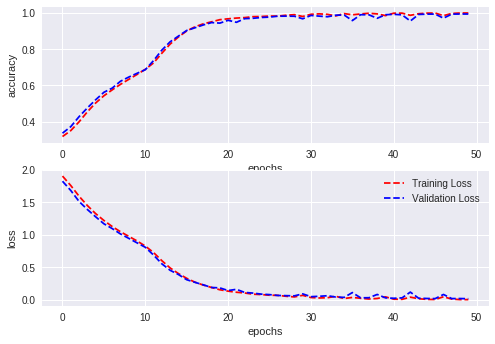

In [162]:
plotloss(history)

# Load saved model

In [0]:
loaded_model = load_model('model_distributed_time.h5')
loaded_model.load_weights('model_weights_distibuted_time.h5')

In [0]:
print(X_test[0])

NameError: name 'X_test' is not defined

In [0]:
loaded_model.evaluate(X_test,y_test)

10000/10000 [==============================] - 6s 562us/step


[0.016943555587530135, 0.99532500000000002]

# GRU

In [154]:
from keras.layers import GRU
modelGRU = Sequential()
modelGRU.add(GRU(128,return_sequences=False,input_shape=(7,12)))
modelGRU.add(RepeatVector(4))
modelGRU.add(GRU(128,return_sequences=True))
modelGRU.add(TimeDistributed(Dense(12)))
modelGRU.add(Activation('softmax'))
modelGRU.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_5 (GRU)                  (None, 128)               54144     
_________________________________________________________________
repeat_vector_8 (RepeatVecto (None, 4, 128)            0         
_________________________________________________________________
gru_6 (GRU)                  (None, 4, 128)            98688     
_________________________________________________________________
time_distributed_8 (TimeDist (None, 4, 12)             1548      
_________________________________________________________________
activation_8 (Activation)    (None, 4, 12)             0         
Total params: 154,380
Trainable params: 154,380
Non-trainable params: 0
_________________________________________________________________


In [148]:
modelGRU.compile(optimizer=Adam(lr=0.001,decay=1e-6),loss='categorical_crossentropy',metrics=['accuracy'])
historyGRU=modelGRU.fit(X_train,y_train,validation_split=0.1,batch_size=128,epochs=50,verbose=1)

Train on 45000 samples, validate on 5000 samples
Epoch 1/50
45000/45000 [==============================] - 10s 221us/step - loss: 1.8671 - acc: 0.3247 - val_loss: 1.7501 - val_acc: 0.3542
Epoch 2/50
45000/45000 [==============================] - 9s 191us/step - loss: 1.6355 - acc: 0.3846 - val_loss: 1.5368 - val_acc: 0.4107
Epoch 3/50
39040/45000 [=========================>....] - ETA: 1s - loss: 1.4395 - acc: 0.4604

45000/45000 [==============================] - 9s 190us/step - loss: 1.4281 - acc: 0.4653 - val_loss: 1.3573 - val_acc: 0.4925
Epoch 4/50
45000/45000 [==============================] - 9s 189us/step - loss: 1.3063 - acc: 0.5127 - val_loss: 1.2685 - val_acc: 0.5293
Epoch 5/50
45000/45000 [==============================] - 8s 188us/step - loss: 1.2439 - acc: 0.5338 - val_loss: 1.2217 - val_acc: 0.5400
Epoch 6/50
19584/45000 [============>.................] - ETA: 4s - loss: 1.2083 - acc: 0.5460

45000/45000 [==============================] - 8s 188us/step - loss: 1.2006 - acc: 0.5478 - val_loss: 1.2091 - val_acc: 0.5351
Epoch 7/50
45000/45000 [==============================] - 9s 189us/step - loss: 1.1574 - acc: 0.5637 - val_loss: 1.1368 - val_acc: 0.5678
Epoch 8/50
45000/45000 [==============================] - 9s 189us/step - loss: 1.0964 - acc: 0.5848 - val_loss: 1.0667 - val_acc: 0.5945
Epoch 9/50
15360/45000 [=========>....................] - ETA: 5s - loss: 1.0363 - acc: 0.6072

45000/45000 [==============================] - 8s 186us/step - loss: 1.0101 - acc: 0.6186 - val_loss: 0.9786 - val_acc: 0.6315
Epoch 10/50
45000/45000 [==============================] - 8s 187us/step - loss: 0.9369 - acc: 0.6486 - val_loss: 0.9136 - val_acc: 0.6554
Epoch 11/50
45000/45000 [==============================] - 8s 188us/step - loss: 0.8804 - acc: 0.6703 - val_loss: 0.8576 - val_acc: 0.6767
Epoch 12/50
14592/45000 [========>.....................] - ETA: 5s - loss: 0.8364 - acc: 0.6882

45000/45000 [==============================] - 8s 185us/step - loss: 0.8219 - acc: 0.6918 - val_loss: 0.8014 - val_acc: 0.6985
Epoch 13/50
45000/45000 [==============================] - 8s 185us/step - loss: 0.7798 - acc: 0.7079 - val_loss: 0.7820 - val_acc: 0.7026
Epoch 14/50
45000/45000 [==============================] - 8s 186us/step - loss: 0.7472 - acc: 0.7210 - val_loss: 0.7471 - val_acc: 0.7191
Epoch 15/50
14848/45000 [========>.....................] - ETA: 5s - loss: 0.7330 - acc: 0.7257

45000/45000 [==============================] - 8s 185us/step - loss: 0.7231 - acc: 0.7300 - val_loss: 0.7166 - val_acc: 0.7294
Epoch 16/50
45000/45000 [==============================] - 8s 186us/step - loss: 0.7066 - acc: 0.7352 - val_loss: 0.6971 - val_acc: 0.7390
Epoch 17/50
45000/45000 [==============================] - 8s 188us/step - loss: 0.6937 - acc: 0.7394 - val_loss: 0.6884 - val_acc: 0.7400
Epoch 18/50
15104/45000 [=========>....................] - ETA: 5s - loss: 0.6795 - acc: 0.7461

45000/45000 [==============================] - 8s 188us/step - loss: 0.6743 - acc: 0.7479 - val_loss: 0.6763 - val_acc: 0.7457
Epoch 19/50
45000/45000 [==============================] - 9s 190us/step - loss: 0.6515 - acc: 0.7571 - val_loss: 0.6735 - val_acc: 0.7438
Epoch 20/50
45000/45000 [==============================] - 9s 190us/step - loss: 0.6204 - acc: 0.7681 - val_loss: 0.6374 - val_acc: 0.7562
Epoch 21/50
13696/45000 [========>.....................] - ETA: 5s - loss: 0.5857 - acc: 0.7808

45000/45000 [==============================] - 8s 189us/step - loss: 0.5569 - acc: 0.7907 - val_loss: 0.5938 - val_acc: 0.7803
Epoch 22/50
45000/45000 [==============================] - 8s 189us/step - loss: 0.4422 - acc: 0.8399 - val_loss: 0.4127 - val_acc: 0.8549
Epoch 23/50
45000/45000 [==============================] - 9s 189us/step - loss: 0.3473 - acc: 0.8823 - val_loss: 0.3253 - val_acc: 0.8896
Epoch 24/50
13568/45000 [========>.....................] - ETA: 5s - loss: 0.3109 - acc: 0.8964

45000/45000 [==============================] - 8s 189us/step - loss: 0.2852 - acc: 0.9069 - val_loss: 0.2800 - val_acc: 0.9044
Epoch 25/50
45000/45000 [==============================] - 9s 190us/step - loss: 0.2181 - acc: 0.9304 - val_loss: 0.2064 - val_acc: 0.9303
Epoch 26/50
45000/45000 [==============================] - 9s 190us/step - loss: 0.1726 - acc: 0.9467 - val_loss: 0.1652 - val_acc: 0.9486
Epoch 27/50
13056/45000 [=======>......................] - ETA: 5s - loss: 0.1450 - acc: 0.9584

45000/45000 [==============================] - 8s 189us/step - loss: 0.1374 - acc: 0.9609 - val_loss: 0.1415 - val_acc: 0.9549
Epoch 28/50
45000/45000 [==============================] - 9s 189us/step - loss: 0.1182 - acc: 0.9667 - val_loss: 0.1090 - val_acc: 0.9701
Epoch 29/50
45000/45000 [==============================] - 8s 187us/step - loss: 0.0858 - acc: 0.9796 - val_loss: 0.1029 - val_acc: 0.9690
Epoch 30/50
12544/45000 [=======>......................] - ETA: 5s - loss: 0.0886 - acc: 0.9765

45000/45000 [==============================] - 8s 186us/step - loss: 0.0822 - acc: 0.9789 - val_loss: 0.0795 - val_acc: 0.9795
Epoch 31/50
45000/45000 [==============================] - 8s 187us/step - loss: 0.0878 - acc: 0.9762 - val_loss: 0.0804 - val_acc: 0.9781
Epoch 32/50
45000/45000 [==============================] - 8s 187us/step - loss: 0.0501 - acc: 0.9899 - val_loss: 0.0507 - val_acc: 0.9884
Epoch 33/50
14208/45000 [========>.....................] - ETA: 5s - loss: 0.0402 - acc: 0.9929

45000/45000 [==============================] - 8s 187us/step - loss: 0.0559 - acc: 0.9861 - val_loss: 0.1022 - val_acc: 0.9679
Epoch 34/50
45000/45000 [==============================] - 8s 187us/step - loss: 0.0457 - acc: 0.9892 - val_loss: 0.0410 - val_acc: 0.9903
Epoch 35/50
45000/45000 [==============================] - 8s 186us/step - loss: 0.0359 - acc: 0.9920 - val_loss: 0.0648 - val_acc: 0.9800
Epoch 36/50
14592/45000 [========>.....................] - ETA: 5s - loss: 0.0429 - acc: 0.9886

45000/45000 [==============================] - 8s 187us/step - loss: 0.0498 - acc: 0.9855 - val_loss: 0.0489 - val_acc: 0.9860
Epoch 37/50
45000/45000 [==============================] - 9s 189us/step - loss: 0.0280 - acc: 0.9941 - val_loss: 0.0551 - val_acc: 0.9835
Epoch 38/50
45000/45000 [==============================] - 9s 191us/step - loss: 0.0350 - acc: 0.9907 - val_loss: 0.0484 - val_acc: 0.9847
Epoch 39/50
13312/45000 [=======>......................] - ETA: 5s - loss: 0.0374 - acc: 0.9894

45000/45000 [==============================] - 9s 192us/step - loss: 0.0488 - acc: 0.9853 - val_loss: 0.0764 - val_acc: 0.9738
Epoch 40/50
45000/45000 [==============================] - 9s 191us/step - loss: 0.0256 - acc: 0.9940 - val_loss: 0.0280 - val_acc: 0.9929
Epoch 41/50
45000/45000 [==============================] - 9s 190us/step - loss: 0.0185 - acc: 0.9960 - val_loss: 0.0713 - val_acc: 0.9769
Epoch 42/50
14080/45000 [========>.....................] - ETA: 5s - loss: 0.0410 - acc: 0.9868

45000/45000 [==============================] - 9s 191us/step - loss: 0.0563 - acc: 0.9820 - val_loss: 0.0287 - val_acc: 0.9925
Epoch 43/50
45000/45000 [==============================] - 9s 192us/step - loss: 0.0130 - acc: 0.9980 - val_loss: 0.0236 - val_acc: 0.9930
Epoch 44/50
45000/45000 [==============================] - 8s 187us/step - loss: 0.0123 - acc: 0.9978 - val_loss: 0.0296 - val_acc: 0.9903
Epoch 45/50
13312/45000 [=======>......................] - ETA: 5s - loss: 0.0890 - acc: 0.9728

45000/45000 [==============================] - 9s 189us/step - loss: 0.0544 - acc: 0.9833 - val_loss: 0.0233 - val_acc: 0.9945
Epoch 46/50
45000/45000 [==============================] - 9s 189us/step - loss: 0.0229 - acc: 0.9939 - val_loss: 0.0136 - val_acc: 0.9972
Epoch 47/50
45000/45000 [==============================] - 9s 189us/step - loss: 0.0082 - acc: 0.9989 - val_loss: 0.0146 - val_acc: 0.9962
Epoch 48/50
13824/45000 [========>.....................] - ETA: 5s - loss: 0.0079 - acc: 0.9988

45000/45000 [==============================] - 8s 189us/step - loss: 0.0078 - acc: 0.9988 - val_loss: 0.0161 - val_acc: 0.9961
Epoch 49/50
45000/45000 [==============================] - 9s 189us/step - loss: 0.0643 - acc: 0.9791 - val_loss: 0.0815 - val_acc: 0.9719
Epoch 50/50
45000/45000 [==============================] - 9s 189us/step - loss: 0.0130 - acc: 0.9971 - val_loss: 0.0131 - val_acc: 0.9968


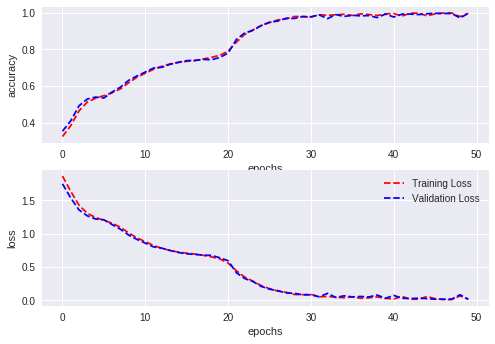

In [156]:
plotloss(historyGRU)

In [153]:
# Your code here
loss,accuracy = model.evaluate(X_test,y_test)
print('loss on test_X:',loss)
print('Accuracy on test_X:',accuracy)

10000/10000 [==============================] - 2s 202us/step
loss on test_X: 0.011853368822857738
Accuracy on test_X: 0.997275


# Reverse the input of data

In [165]:
modelRV = Sequential()
modelRV.add(LSTM(128,return_sequences=False,input_shape=(7,12),go_backwards=True))
modelRV.add(RepeatVector(4))
modelRV.add(LSTM(128,return_sequences=True))
modelRV.add(TimeDistributed(Dense(12)))
modelRV.add(Activation('softmax'))
modelRV.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 128)               72192     
_________________________________________________________________
repeat_vector_11 (RepeatVect (None, 4, 128)            0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 4, 128)            131584    
_________________________________________________________________
time_distributed_11 (TimeDis (None, 4, 12)             1548      
_________________________________________________________________
activation_11 (Activation)   (None, 4, 12)             0         
Total params: 205,324
Trainable params: 205,324
Non-trainable params: 0
_________________________________________________________________


In [167]:
modelRV.compile(optimizer=Adam(lr=0.001,decay=1e-6),loss='categorical_crossentropy',metrics=['accuracy'])
historyRV=modelRV.fit(X_train,y_train,validation_split=0.1,batch_size=128,epochs=50,verbose=1)

Train on 45000 samples, validate on 5000 samples
Epoch 1/50
45000/45000 [==============================] - 13s 281us/step - loss: 1.8989 - acc: 0.3185 - val_loss: 1.7846 - val_acc: 0.3356
Epoch 2/50
45000/45000 [==============================] - 11s 236us/step - loss: 1.7369 - acc: 0.3599 - val_loss: 1.6673 - val_acc: 0.3760
Epoch 3/50
14720/45000 [========>.....................] - ETA: 6s - loss: 1.6363 - acc: 0.3906

45000/45000 [==============================] - 11s 234us/step - loss: 1.5836 - acc: 0.4057 - val_loss: 1.5090 - val_acc: 0.4291
Epoch 4/50
45000/45000 [==============================] - 10s 232us/step - loss: 1.4322 - acc: 0.4642 - val_loss: 1.3677 - val_acc: 0.4854
Epoch 5/50
35712/45000 [======================>.......] - ETA: 2s - loss: 1.3048 - acc: 0.5148

45000/45000 [==============================] - 11s 237us/step - loss: 1.2932 - acc: 0.5199 - val_loss: 1.2285 - val_acc: 0.5476
Epoch 6/50
45000/45000 [==============================] - 11s 239us/step - loss: 1.1778 - acc: 0.5636 - val_loss: 1.1485 - val_acc: 0.5665
Epoch 7/50
40576/45000 [==========================>...] - ETA: 0s - loss: 1.0643 - acc: 0.6084

45000/45000 [==============================] - 10s 225us/step - loss: 1.0592 - acc: 0.6105 - val_loss: 0.9996 - val_acc: 0.6401
Epoch 8/50
45000/45000 [==============================] - 10s 225us/step - loss: 0.9559 - acc: 0.6553 - val_loss: 0.9336 - val_acc: 0.6631
Epoch 9/50
41600/45000 [==========================>...] - ETA: 0s - loss: 0.8738 - acc: 0.6864

45000/45000 [==============================] - 10s 223us/step - loss: 0.8719 - acc: 0.6871 - val_loss: 0.8322 - val_acc: 0.7032
Epoch 10/50
45000/45000 [==============================] - 10s 218us/step - loss: 0.7980 - acc: 0.7156 - val_loss: 0.7717 - val_acc: 0.7217
Epoch 11/50
41600/45000 [==========================>...] - ETA: 0s - loss: 0.7349 - acc: 0.7402

45000/45000 [==============================] - 10s 221us/step - loss: 0.7323 - acc: 0.7414 - val_loss: 0.7033 - val_acc: 0.7457
Epoch 12/50
45000/45000 [==============================] - 10s 220us/step - loss: 0.6480 - acc: 0.7683 - val_loss: 0.6047 - val_acc: 0.7762
Epoch 13/50
41728/45000 [==========================>...] - ETA: 0s - loss: 0.5141 - acc: 0.8183

45000/45000 [==============================] - 10s 219us/step - loss: 0.5082 - acc: 0.8207 - val_loss: 0.4342 - val_acc: 0.8538
Epoch 14/50
45000/45000 [==============================] - 10s 221us/step - loss: 0.3692 - acc: 0.8820 - val_loss: 0.3107 - val_acc: 0.9099
Epoch 15/50
41600/45000 [==========================>...] - ETA: 0s - loss: 0.2593 - acc: 0.9325

45000/45000 [==============================] - 10s 230us/step - loss: 0.2565 - acc: 0.9337 - val_loss: 0.2483 - val_acc: 0.9338
Epoch 16/50
45000/45000 [==============================] - 10s 231us/step - loss: 0.1813 - acc: 0.9606 - val_loss: 0.1548 - val_acc: 0.9663
Epoch 17/50
41600/45000 [==========================>...] - ETA: 0s - loss: 0.1328 - acc: 0.9738

45000/45000 [==============================] - 10s 230us/step - loss: 0.1325 - acc: 0.9737 - val_loss: 0.1383 - val_acc: 0.9634
Epoch 18/50
45000/45000 [==============================] - 10s 227us/step - loss: 0.1016 - acc: 0.9801 - val_loss: 0.0919 - val_acc: 0.9811
Epoch 19/50
41600/45000 [==========================>...] - ETA: 0s - loss: 0.0728 - acc: 0.9886

45000/45000 [==============================] - 10s 230us/step - loss: 0.0719 - acc: 0.9887 - val_loss: 0.0731 - val_acc: 0.9865
Epoch 20/50
45000/45000 [==============================] - 10s 231us/step - loss: 0.0776 - acc: 0.9826 - val_loss: 0.0584 - val_acc: 0.9892
Epoch 21/50
41600/45000 [==========================>...] - ETA: 0s - loss: 0.0517 - acc: 0.9912

45000/45000 [==============================] - 10s 231us/step - loss: 0.0517 - acc: 0.9911 - val_loss: 0.0595 - val_acc: 0.9859
Epoch 22/50
45000/45000 [==============================] - 10s 225us/step - loss: 0.0382 - acc: 0.9949 - val_loss: 0.0420 - val_acc: 0.9917
Epoch 23/50
41600/45000 [==========================>...] - ETA: 0s - loss: 0.0372 - acc: 0.9939

45000/45000 [==============================] - 10s 221us/step - loss: 0.0368 - acc: 0.9939 - val_loss: 0.0488 - val_acc: 0.9870
Epoch 24/50
45000/45000 [==============================] - 10s 220us/step - loss: 0.0462 - acc: 0.9892 - val_loss: 0.0306 - val_acc: 0.9944
Epoch 25/50
41600/45000 [==========================>...] - ETA: 0s - loss: 0.0217 - acc: 0.9977

45000/45000 [==============================] - 10s 231us/step - loss: 0.0218 - acc: 0.9976 - val_loss: 0.0324 - val_acc: 0.9928
Epoch 26/50
45000/45000 [==============================] - 11s 235us/step - loss: 0.0215 - acc: 0.9972 - val_loss: 0.0368 - val_acc: 0.9900
Epoch 27/50
41600/45000 [==========================>...] - ETA: 0s - loss: 0.0474 - acc: 0.9870

45000/45000 [==============================] - 10s 231us/step - loss: 0.0450 - acc: 0.9878 - val_loss: 0.0229 - val_acc: 0.9952
Epoch 28/50
45000/45000 [==============================] - 10s 230us/step - loss: 0.0129 - acc: 0.9991 - val_loss: 0.0173 - val_acc: 0.9970
Epoch 29/50
41600/45000 [==========================>...] - ETA: 0s - loss: 0.0142 - acc: 0.9983

45000/45000 [==============================] - 10s 224us/step - loss: 0.0242 - acc: 0.9952 - val_loss: 0.1831 - val_acc: 0.9344
Epoch 30/50
45000/45000 [==============================] - 10s 221us/step - loss: 0.0327 - acc: 0.9913 - val_loss: 0.0172 - val_acc: 0.9970
Epoch 31/50
41600/45000 [==========================>...] - ETA: 0s - loss: 0.0114 - acc: 0.9988

45000/45000 [==============================] - 10s 226us/step - loss: 0.0112 - acc: 0.9988 - val_loss: 0.0116 - val_acc: 0.9983
Epoch 32/50
45000/45000 [==============================] - 10s 231us/step - loss: 0.0075 - acc: 0.9996 - val_loss: 0.0112 - val_acc: 0.9982
Epoch 33/50
41088/45000 [==========================>...] - ETA: 0s - loss: 0.0443 - acc: 0.9873

45000/45000 [==============================] - 11s 233us/step - loss: 0.0423 - acc: 0.9879 - val_loss: 0.0203 - val_acc: 0.9956
Epoch 34/50
45000/45000 [==============================] - 10s 231us/step - loss: 0.0087 - acc: 0.9993 - val_loss: 0.0104 - val_acc: 0.9983
Epoch 35/50
41344/45000 [==========================>...] - ETA: 0s - loss: 0.0056 - acc: 0.9998

45000/45000 [==============================] - 10s 227us/step - loss: 0.0057 - acc: 0.9998 - val_loss: 0.0095 - val_acc: 0.9986
Epoch 36/50
45000/45000 [==============================] - 10s 230us/step - loss: 0.0051 - acc: 0.9998 - val_loss: 0.0082 - val_acc: 0.9989
Epoch 37/50
41344/45000 [==========================>...] - ETA: 0s - loss: 0.0336 - acc: 0.9898

45000/45000 [==============================] - 10s 232us/step - loss: 0.0348 - acc: 0.9894 - val_loss: 0.0473 - val_acc: 0.9838
Epoch 38/50
45000/45000 [==============================] - 10s 230us/step - loss: 0.0216 - acc: 0.9945 - val_loss: 0.0171 - val_acc: 0.9958
Epoch 39/50
41344/45000 [==========================>...] - ETA: 0s - loss: 0.0052 - acc: 0.9997

45000/45000 [==============================] - 10s 231us/step - loss: 0.0051 - acc: 0.9997 - val_loss: 0.0072 - val_acc: 0.9987
Epoch 40/50
45000/45000 [==============================] - 10s 227us/step - loss: 0.0036 - acc: 0.9999 - val_loss: 0.0061 - val_acc: 0.9991
Epoch 41/50
41344/45000 [==========================>...] - ETA: 0s - loss: 0.0033 - acc: 0.9998

45000/45000 [==============================] - 11s 234us/step - loss: 0.0034 - acc: 0.9998 - val_loss: 0.0084 - val_acc: 0.9979
Epoch 42/50
45000/45000 [==============================] - 10s 232us/step - loss: 0.0319 - acc: 0.9904 - val_loss: 0.0126 - val_acc: 0.9971
Epoch 43/50
41344/45000 [==========================>...] - ETA: 0s - loss: 0.0042 - acc: 0.9997

45000/45000 [==============================] - 10s 224us/step - loss: 0.0042 - acc: 0.9997 - val_loss: 0.0065 - val_acc: 0.9984
Epoch 44/50
45000/45000 [==============================] - 10s 230us/step - loss: 0.0028 - acc: 0.9999 - val_loss: 0.0054 - val_acc: 0.9990
Epoch 45/50
41344/45000 [==========================>...] - ETA: 0s - loss: 0.0024 - acc: 0.9999

45000/45000 [==============================] - 10s 231us/step - loss: 0.0025 - acc: 0.9999 - val_loss: 0.0052 - val_acc: 0.9990
Epoch 46/50
45000/45000 [==============================] - 10s 233us/step - loss: 0.0424 - acc: 0.9875 - val_loss: 0.0119 - val_acc: 0.9970
Epoch 47/50
41344/45000 [==========================>...] - ETA: 0s - loss: 0.0042 - acc: 0.9997

45000/45000 [==============================] - 10s 231us/step - loss: 0.0041 - acc: 0.9997 - val_loss: 0.0054 - val_acc: 0.9990
Epoch 48/50
45000/45000 [==============================] - 10s 231us/step - loss: 0.0024 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9991
Epoch 49/50
41344/45000 [==========================>...] - ETA: 0s - loss: 0.0020 - acc: 1.0000

45000/45000 [==============================] - 10s 233us/step - loss: 0.0020 - acc: 1.0000 - val_loss: 0.0042 - val_acc: 0.9991
Epoch 50/50
45000/45000 [==============================] - 10s 233us/step - loss: 0.0018 - acc: 1.0000 - val_loss: 0.0040 - val_acc: 0.9992


In [168]:
loss,accuracy = modelRV.evaluate(X_test,y_test)
print('loss on test_X:',loss)
print('Accuracy on test_X:',accuracy)

10000/10000 [==============================] - 2s 234us/step
loss on test_X: 0.004069947195611894
Accuracy on test_X: 0.999425


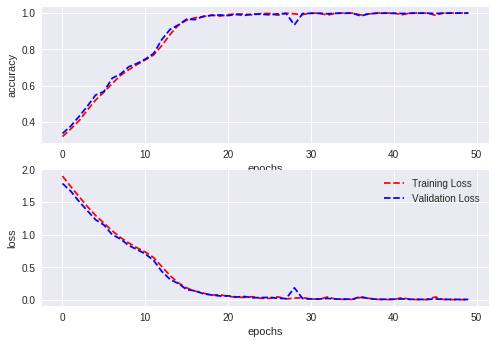

In [169]:
plotloss(historyRV)

In [171]:
def char_to_categorical(inputs):
  return np_utils.to_categorical([char_to_int[char] for char in inputs],len(chars)).reshape([1,7,12])

answerMaps = {0:0 , 1:1 ,2:2, 3:3, 4:4 ,5:5,6:6,7:7,8:8,9:9,10:'+',11:' '}
inputs = '15+15  '
myinput = char_to_categorical(inputs)
print(([answerMaps[idx] for idx in modelRV.predict(myinput).argmax(axis=2).flatten()])[0:3])

[3, 0, ' ']


In [0]:
model.save_weights('model_weights_RV.h5')
model.save('model_distributed_RV.h5')

In [173]:
!gsutil cp model_weights_RV.h5 gs://myharddisk-1
!gsutil cp model_distributed_RV.h5 gs://myharddisk-1

Copying file://model_weights_RV.h5 [Content-Type=application/octet-stream]...
-
Operation completed over 1 objects/818.1 KiB.                                    
Copying file://model_distributed_RV.h5 [Content-Type=application/octet-stream]...
-
Operation completed over 1 objects/2.4 MiB.                                      
